# 한글문서 요약 및 semantic segmentation

1. 추출적 요약<br>
원문에서 중요한 핵심 문장 또는 단어구를 몇 개 뽑아서 요약문을 만드는 방법
2. 추상적 요약<br>
원문에 없던 문장이라도 핵심 문맥을 반영한 새로운 문장을 생성하는 방법. 원문 뿐만 아니라 실제 요약문이라는 레이블 데이터가 있어야한다.

# 문서요약

## 1. 라이브러리 호출

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import tensorflow as tf
import warnings
from tqdm.notebook import tqdm

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

warnings.filterwarnings('ignore')
np.random.seed(seed=42)
tf.random.set_seed(42)

## 2. 데이터 불러오기

#### jsonl 불러오기

In [ ]:
import json

def load_jsonl(input_path) -> list: #jsonl은 각 line이 json객체로 저장되어있는 형식
    """
    Read list of objects from a JSON lines file.
    """
    data = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.rstrip('\n|\r')))
    print('Loaded {} records from {}'.format(len(data), input_path))
    return data

In [ ]:
jsl_1 = load_jsonl(r"sample_법률문서.jsonl")
jsl_2 = load_jsonl(r"sample_사설잡지.jsonl")
jsl_3 = load_jsonl(r"sample_신문기사.jsonl")

df_1 = pd.DataFrame(jsl_1)
df_2 = pd.DataFrame(jsl_2)
df_3 = pd.DataFrame(jsl_3)

#sementic segmentation에 사용할 라벨 생성
df_1['label'] = int(0)
df_2['label'] = int(1)
df_3['label'] = int(2)

df = pd.concat([df_1, df_2, df_3])
df.reset_index(inplace=True, drop=True)
df.head()

Loaded 300 records from sample_법률문서.jsonl
Loaded 700 records from sample_사설잡지.jsonl
Loaded 3012 records from sample_신문기사.jsonl


,id,abstractive,extractive,article_original,label,media
0,121009,시어머니가 아들이 처자를 내버려둔 채 다른 여자를 데리고 자신의 집으로 들어와 동거...,"[5, 0, 6]",[시어머니가 아들이 그 처자를 내버려둔 채 다른 여자와 동거하기 위해 그 여자를 집...,0,NaN
1,189182,호적정정신청절차에 의한 호적정정은 정정할 사항이 경미한 경우에 한하고 친족법상 또는...,"[0, 3, 4]",[호적정정신청절차에 의한 호적정정은 정정절차가 간이함에 비추어 정정할 사항이 경미한...,0,NaN
2,98479,수인의 개인 용달화물 자동차운송사업자들이 사무실 등을 운영키 위한 경비를 공동으로 ...,"[4, 5, 6]",[피고인을 비롯하여 용달화물 자동차운송사업 개인별 면허를 얻어 용달차 한 대씩을 각...,0,NaN
3,122769,"출원상표(1) "" ""와 출원상표(2) "" 는 식별력을 인정하기 어렵고, 의약품을 취...","[0, 7, 10]","[출원상표(1) "" ""와 출원상표(2) "" ""은 상품구분 제10류의 상품군 제4에 ...",0,NaN
4,106112,피고인 운전의 트럭이 피해자 운전의 오토바이를 추월하기 위하여 우측으로 너무 근접하...,"[1, 2, 3]",[가. 피의자이던 피고인이 사법경찰리의 면전에서 자백한 진술에 따라 사고 당시의 상...,0,NaN


## 3. 한글문서 전처리

#### 불필요 칼럼제거 및 null확인

In [ ]:
data = df[['article_original', 'abstractive', 'label']]
data.isnull().sum()

article_original    0
abstractive         0
label               0
dtype: int64

In [ ]:
data.head()

,article_original,abstractive,label
0,[시어머니가 아들이 그 처자를 내버려둔 채 다른 여자와 동거하기 위해 그 여자를 집...,시어머니가 아들이 처자를 내버려둔 채 다른 여자를 데리고 자신의 집으로 들어와 동거...,0
1,[호적정정신청절차에 의한 호적정정은 정정절차가 간이함에 비추어 정정할 사항이 경미한...,호적정정신청절차에 의한 호적정정은 정정할 사항이 경미한 경우에 한하고 친족법상 또는...,0
2,[피고인을 비롯하여 용달화물 자동차운송사업 개인별 면허를 얻어 용달차 한 대씩을 각...,수인의 개인 용달화물 자동차운송사업자들이 사무실 등을 운영키 위한 경비를 공동으로 ...,0
3,"[출원상표(1) "" ""와 출원상표(2) "" ""은 상품구분 제10류의 상품군 제4에 ...","출원상표(1) "" ""와 출원상표(2) "" 는 식별력을 인정하기 어렵고, 의약품을 취...",0
4,[가. 피의자이던 피고인이 사법경찰리의 면전에서 자백한 진술에 따라 사고 당시의 상...,피고인 운전의 트럭이 피해자 운전의 오토바이를 추월하기 위하여 우측으로 너무 근접하...,0


In [ ]:
data['article_original'][0]

['시어머니가 아들이 그 처자를 내버려둔 채 다른 여자와 동거하기 위해 그 여자를 집으로 데리고 왔음에도 이를 적극적으로 제지하거나 설득하여 아들로 하여금 원만한 부부관계와 가정생활을 이루도록 노력을 기울이지 아니하였음은 물론 며느리가 아들보다 연상이라는 점에 대해 며느리를 못마땅하게 여기고,',
 '다른 여자로 하여금 자기가 거주하는 집에서 아들과의 동거를 허용함으로써 동거장소를 제공하였을 뿐만 아니라,',
 '식사와 빨래 등 일상 가사일을 맡겨 그 여자로부터 봉양받는 한편,',
 '며느리에게는 시아버지의 사망사실조차 알리지 아니하고,',
 '며느리 대신에 그 여자로 하여금 상복을 입혀 장례에 참석하게 하거나 추석 차례에까지 참석하게 하는 등 그 여자에게 사실상 며느리로서의 역할을 하게 한 경우,',
 '시어머니가 아들부부 사이의 혼인파탄의 원인된 행위에 가담한 것으로써',
 '위자료 지급 책임이 있다고 본 사례.']

#### Basic Preprocessing

In [ ]:
#구두점 제거
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi'}

def clean_punc(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text.strip()

#불필요 문자 제거
import re

def clean_text(texts):
    corpus = []
    for i in range(0, len(texts)):
        review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"]', '',str(texts[i])) #remove punctuation
        review = re.sub(r'\d+','', review)# remove number
        review = review.lower() #lower case
        review = re.sub(r'\s+', ' ', review) #remove extra space
        review = re.sub(r'<[^>]+>','',review) #remove Html tags
        review = re.sub(r'\([^)]*\)', '', review) # 괄호로 닫힌 문자열  제거
        review = re.sub(r'\s+', ' ', review) #remove spaces
        review = re.sub(r"^\s+", '', review) #remove space from start
        review = re.sub(r'\s+$', '', review) #remove space from the end
        corpus.append(review)
    return corpus

def clean_text_summary(texts):
    review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"]', '',str(texts)) #remove punctuation
    review = re.sub(r'\d+','', review)# remove number
    review = review.lower() #lower case
    review = re.sub(r'\s+', ' ', review) #remove extra space
    review = re.sub(r'<[^>]+>','',review) #remove Html tags
    review = re.sub(r'\([^)]*\)', '', review) # 괄호로 닫힌 문자열  제거
    review = re.sub(r'\s+', ' ', review) #remove spaces
    review = re.sub(r"^\s+", '', review) #remove space from start
    review = re.sub(r'\s+$', '', review) #remove space from the end
    return review


#clean_punc 적용
data['cleaned_article_original'] = data['article_original'].apply(lambda x : [clean_punc(sent, punct, punct_mapping) for sent in x])
data['pre_abstractive'] = data['abstractive'].apply(lambda x : clean_punc(x, punct, punct_mapping))

#clean_text 적용
data['cleaned_article_original'] = data['cleaned_article_original'].apply(clean_text)
data['pre_abstractive'] = data['pre_abstractive'].apply(clean_text_summary)

#### Spell checking

In [ ]:
# !pip install git+https://github.com/haven-jeon/PyKoSpacing.git #띄어쓰기
# !pip install git+https://github.com/ssut/py-hanspell.git #맞춤법 확인
# !pip install soynlp #이모티콘이나 자모를 normalization

In [ ]:
#외래어 사전 다운로드
!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1RNYpLE-xbMCGtiEHIoNsCmfcyJP3kLYn" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1RNYpLE-xbMCGtiEHIoNsCmfcyJP3kLYn" -o confused_loanwords.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0    953      0 --:--:-- --:--:-- --:--:--   951
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 19779  100 19779    0     0  10708      0  0:00:01  0:00:01 --:--:-- 10708


In [ ]:
#띄어쓰기
from pykospacing import Spacing

#맞춤법 확인
from hanspell import spell_checker

#이모티콘, 자모
from soynlp.normalizer import * 

#외래어
lownword_map = {}
lownword_data = open('/content/confused_loanwords.txt', 'r', encoding='utf-8')

lines = lownword_data.readlines()

for line in lines:
    line = line.strip()
    miss_spell = line.split('\t')[0]
    ori_word = line.split('\t')[1]
    lownword_map[miss_spell] = ori_word

In [ ]:
spacing=Spacing()

def spell_check_text(texts):
    corpus = []
    for sent in tqdm(texts):
        spaced_text = spacing.get_spaced_sent(sent)
        spelled_sent = spell_checker.check(spaced_text)
        checked_sent = spelled_sent.checked
        normalized_sent = repeat_normalize(checked_sent)
        for lownword in lownword_map:
            normalized_sent = normalized_sent.replace(lownword, lownword_map[lownword])
        corpus.append(normalized_sent)
    return corpus

def spell_check_text_summary(texts):
    spaced_text = spacing.get_spaced_sent(texts)
    spelled_sent = spell_checker.check(spaced_text)
    checked_sent = spelled_sent.checked
    normalized_sent = repeat_normalize(checked_sent)
    for lownword in lownword_map:
        normalized_sent = normalized_sent.replace(lownword, lownword_map[lownword])

    return normalized_sent

# 띄어쓰기, 맞춤법, 외래어처리
# data['cleaned_article_original'] = data['cleaned_article_original'].apply(spell_check_text)
# data['pre_abstractive'] = data['pre_abstractive'].apply(spell_check_text_summary)

# tokenize 전 summary 저장
data['pre_abstractive_original'] = data['pre_abstractive']

#### 형태소 분석, KhaiiiApi사용

In [ ]:
# !git clone https://github.com/kakao/khaiii.git
# !pip install cmake
# !mkdir build
# !cd build && cmake /content/khaiii
# !cd /content/build/ && make all
# !cd /content/build/ && make resource
# !cd /content/build && make install
# !cd /content/build && make package_python
# !pip install /content/build/package_python

In [ ]:
# 공백문서 제거
def remove_null(texts):
    doc = []
    for sent in texts:
        if sent != '':
            doc.append(sent)
    return doc

def remove_null_summary(texts):
    if texts != '':
        return texts
    else:
        return np.nan

# 앞의 과정에서 생긴 공백 제거
data['cleaned_article_original'] = data['cleaned_article_original'].apply(remove_null)
data['pre_abstractive'] = data['pre_abstractive'].apply(remove_null_summary)

In [ ]:
data.isna().sum()

article_original            0
abstractive                 0
label                       0
cleaned_article_original    0
pre_abstractive             0
pre_abstractive_original    0
dtype: int64

In [ ]:
from khaiii import KhaiiiApi

api = KhaiiiApi()
significant_tags = ['NNG', 'NNP', 'NNB', 'VV', 'VA', 'VX', 'MAG', 'MAJ', 'XSV', 'XSA']

def pos_text(texts):
    corpus = []
    for sent in texts:
        pos_tagged = ''
        for word in api.analyze(sent):
            for morph in word.morphs:
                if morph.tag in significant_tags:
                    pos_tagged += (morph.lex + '/' + morph.tag + ' ')
        corpus.append(pos_tagged.strip())
    return corpus

def pos_text_summary(sent):
    pos_tagged = ''
    for word in api.analyze(sent):
        for morph in word.morphs:
            if morph.tag in significant_tags:
                pos_tagged += (morph.lex + '/' + morph.tag + ' ')
    
    return pos_tagged

#형태소 분석
data['cleaned_article_original'] = data['cleaned_article_original'].apply(lambda x : pos_text(x))
data['pre_abstractive'] = data['pre_abstractive'].apply(pos_text_summary)

In [ ]:
data['cleaned_article_original'][0]

['시어머니/NNG 아들/NNG 처자/NNG 내버리/VV 두/VX 채/NNB 여자/NNG 동거/NNG 하/XSV 위하/VV 여자/NNG 집/NNG 데리/VV 오/VV 적극/NNG 제지/NNG 하/XSV 설득/NNG 하/XSV 아들/NNG 하여금/MAG 하/XSA 부부/NNG 관계/NNG 가정/NNG 생활/NNG 이루/VV 노력/NNG 기울이/VV 아니하/VX 물론/MAG 며느리/NNG 아들/NNG 연상/NNG 점/NNG 대하/VV 며느리/NNG 하/XSA 여기/VV',
 '여자/NNG 하여금/MAG 거주/NNG 하/XSV 집/NNG 아들/NNG 동거/NNG 허용/NNG 하/XSV 동거/NNG 장소/NNG 제공/NNG 하/XSV 뿐/NNB',
 '식사/NNG 빨래/NNG 등/NNB 일상/NNG 가사일/NNG 맡기/VV 여자/NNG 봉양/NNG 받/VV 한편/NNG',
 '며느리/NNG 시아버지/NNG 사망/NNG 사실/NNG 알리/VV 아니하/VX',
 '며느리/NNG 대신/NNG 여자/NNG 하여금/MAG 상복/NNG 입히/VV 장례/NNG 참석/NNG 하/XSV 하/VX 추석/NNG 차례/NNG 참석/NNG 하/XSV 하/VX 등/NNB 여자/NNG 사실/NNG 며느리/NNG 역할/NNG 하/VV 하/VX 경우/NNG',
 '시어머니/NNG 아들부부/NNG 사이/NNG 혼인/NNG 파탄/NNG 원인/NNG 되/XSV 행위/NNG 가담/NNG 하/XSV 것/NNB',
 '위자료/NNG 지급/NNG 책임/NNG 있/VV 보/VV 사례/NNG']

#### stemming

In [ ]:
p1 = re.compile('[가-힣A-Za-z0-9]+/NN. [가-힣A-Za-z0-9]+/XS.')
p2 = re.compile('[가-힣A-Za-z0-9]+/NN. [가-힣A-Za-z0-9]+/XSA [가-힣A-Za-z0-9]+/VX')
p3 = re.compile('[가-힣A-Za-z0-9]+/VV')
p4 = re.compile('[가-힣A-Za-z0-9]+/VX')

In [ ]:
def stemming_text(text):
    corpus = []
    for sent in text:
        ori_sent = sent
        mached_terms = re.findall(p1, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                modi_terms += lemma
            modi_terms += '다/VV'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)
        
        mached_terms = re.findall(p2, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                if tag != 'VX':
                    modi_terms += lemma
            modi_terms += '다/VV'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)

        mached_terms = re.findall(p3, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                modi_terms += lemma
            if '다' != modi_terms[-1]:
                modi_terms += '다'
            modi_terms += '/VV'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)

        mached_terms = re.findall(p4, ori_sent)
        for terms in mached_terms:
            ori_terms = terms
            modi_terms = ''
            for term in terms.split(' '):
                lemma = term.split('/')[0]
                tag = term.split('/')[-1]
                modi_terms += lemma
            if '다' != modi_terms[-1]:
                modi_terms += '다'
            modi_terms += '/VV'
            ori_sent = ori_sent.replace(ori_terms, modi_terms)
        corpus.append(ori_sent)
    return corpus

def stemming_text_summary(sent):
    ori_sent = sent
    mached_terms = re.findall(p1, ori_sent)
    for terms in mached_terms:
        ori_terms = terms
        modi_terms = ''
        for term in terms.split(' '):
            lemma = term.split('/')[0]
            tag = term.split('/')[-1]
            modi_terms += lemma
        modi_terms += '다/VV'
        ori_sent = ori_sent.replace(ori_terms, modi_terms)
    
    mached_terms = re.findall(p2, ori_sent)
    for terms in mached_terms:
        ori_terms = terms
        modi_terms = ''
        for term in terms.split(' '):
            lemma = term.split('/')[0]
            tag = term.split('/')[-1]
            if tag != 'VX':
                modi_terms += lemma
        modi_terms += '다/VV'
        ori_sent = ori_sent.replace(ori_terms, modi_terms)

    mached_terms = re.findall(p3, ori_sent)
    for terms in mached_terms:
        ori_terms = terms
        modi_terms = ''
        for term in terms.split(' '):
            lemma = term.split('/')[0]
            tag = term.split('/')[-1]
            modi_terms += lemma
        if '다' != modi_terms[-1]:
            modi_terms += '다'
        modi_terms += '/VV'
        ori_sent = ori_sent.replace(ori_terms, modi_terms)

    mached_terms = re.findall(p4, ori_sent)
    for terms in mached_terms:
        ori_terms = terms
        modi_terms = ''
        for term in terms.split(' '):
            lemma = term.split('/')[0]
            tag = term.split('/')[-1]
            modi_terms += lemma
        if '다' != modi_terms[-1]:
            modi_terms += '다'
        modi_terms += '/VV'
        ori_sent = ori_sent.replace(ori_terms, modi_terms)

    return ori_sent

#stemming
data['cleaned_article_original'] = data['cleaned_article_original'].apply(stemming_text)
data['pre_abstractive'] = data['pre_abstractive'].apply(stemming_text_summary)

#### 불용어처리

In [ ]:
stopwords = ['데/NNB', '좀/MAG', '수/NNB', '등/NNB',  '지나다/VV', '데', '좀', '수', '등', '지난']

def remove_stopword_text(text):
    corpus = []
    for sent in text:
        modi_sent = []
        for word in sent.split(' '):
            if word not in stopwords:
                modi_sent.append(word)
        corpus.append(' '.join(modi_sent))
    return corpus

def remove_stopword_text_summary(sent):
    modi_sent = []
    for word in sent.split(' '):
        if word not in stopwords:
            modi_sent.append(word)
    return modi_sent

#불용어 제거
data['cleaned_article_original'] = data['cleaned_article_original'].apply(remove_stopword_text)
data['pre_abstractive'] = data['pre_abstractive'].apply(remove_stopword_text_summary)

#전처리 완료된 column생성
data['pre_article_original'] = data['cleaned_article_original']

#segmentation을 위한 데이터저장
seg_data = data[['pre_article_original', 'pre_abstractive', 'label']]

#### 전처리 완료된 데이터 생성

In [ ]:
data = data[['pre_article_original', 'pre_abstractive_original', 'article_original']]
data.columns = ['Text', 'Summary', 'Text_original']

data.isna().sum()

Text             0
Summary          0
Text_original    0
dtype: int64

In [ ]:
# article을 한 문서로 저장

def to_doc(text):
    doc = text[0]
    for i in range(1, len(text)):
        doc += ' '
        doc += text[i]
    return doc

data['Text'] = data['Text'].apply(to_doc)
data['Text_original'] = data['Text_original'].apply(to_doc)
data.head()

,Text,Summary,Text_original
0,시어머니/NNG 아들/NNG 처자/NNG 내버리다/VV 두다/VV 채/NNB 여자/...,시어머니가 아들이 처자를 내버려둔 채 다른 여자를 데리고 자신의 집으로 들어와 동거...,시어머니가 아들이 그 처자를 내버려둔 채 다른 여자와 동거하기 위해 그 여자를 집으...
1,호/NNG 정정/NNG 신청절차/NNG 의하다/VV 호적/NNG 정정/NNG 정정/...,호적정정신청절차에 의한 호적정정은 정정할 사항이 경미한 경우에 한하고 친족법상 또는...,호적정정신청절차에 의한 호적정정은 정정절차가 간이함에 비추어 정정할 사항이 경미한 ...
2,피고인하다/VV 용달화물/NNG 자동차/NNG 운송/NNG 사업/NNG 개인/NNG...,수인의 개인 용달화물 자동차운송사업자들이 사무실 등을 운영키 위한 경비를 공동으로 ...,피고인을 비롯하여 용달화물 자동차운송사업 개인별 면허를 얻어 용달차 한 대씩을 각 ...
3,출원/NNG 상표/NNG 출원/NNG 상표/NNG 상품/NNG 구분/NNG 제류/N...,출원상표 와 출원상표 는 식별력을 인정하기 어렵고 의약품을 취급하는 곳에서 농업용 ...,"출원상표(1) "" ""와 출원상표(2) "" ""은 상품구분 제10류의 상품군 제4에 속..."
4,가/NNG 피의자/NNG 피고인/NNG 사법/NNG 경찰/NNG 리/NNP 면전/N...,피고인 운전의 트럭이 피해자 운전의 오토바이를 추월하기 위하여 우측으로 너무 근접하...,가. 피의자이던 피고인이 사법경찰리의 면전에서 자백한 진술에 따라 사고 당시의 상황...


In [ ]:
data['Text'][0]

'시어머니/NNG 아들/NNG 처자/NNG 내버리다/VV 두다/VV 채/NNB 여자/NNG 동거하다/VV 위하다/VV 여자/NNG 집/NNG 데리다/VV 오다/VV 적극/NNG 제지하다/VV 설득하다/VV 아들/NNG 하여금/MAG 하/XSA 부부/NNG 관계/NNG 가정/NNG 생활/NNG 이루다/VV 노력/NNG 기울이다/VV 아니하다/VV 물론/MAG 며느리/NNG 아들/NNG 연상/NNG 점/NNG 대하다/VV 며느리하다/VV 여기다/VV 여자/NNG 하여금/MAG 거주하다/VV 집/NNG 아들/NNG 동거/NNG 허용하다/VV 동거/NNG 장소/NNG 제공하다/VV 뿐/NNB 식사/NNG 빨래/NNG 일상/NNG 가사일/NNG 맡기다/VV 여자/NNG 봉양/NNG 받다/VV 한편/NNG 며느리/NNG 시아버지/NNG 사망/NNG 사실/NNG 알리다/VV 아니하다/VV 며느리/NNG 대신/NNG 여자/NNG 하여금/MAG 상복/NNG 입히다/VV 장례/NNG 참석하다/VV 하다/VV 추석/NNG 차례/NNG 참석하다/VV 하다/VV 여자/NNG 사실/NNG 며느리/NNG 역할/NNG 하다/VV 하다/VV 경우/NNG 시어머니/NNG 아들부부/NNG 사이/NNG 혼인/NNG 파탄/NNG 원인되다/VV 행위/NNG 가담하다/VV 것/NNB 위자료/NNG 지급/NNG 책임/NNG 있다/VV 보다/VV 사례/NNG'

## 4. EDA

#### 원문 및 요약본 텍스트 길이분포 확인

텍스트의 최소 길이 : 40
텍스트의 최대 길이 : 505
텍스트의 평균 길이 : 244.14656031904286
요약의 최소 길이 : 8
요약의 최대 길이 : 127
요약의 평균 길이 : 30.267447657028914


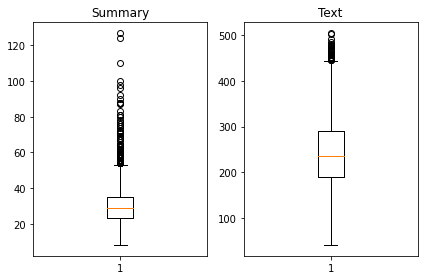

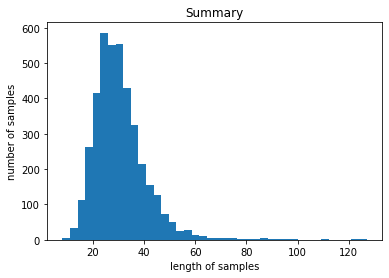

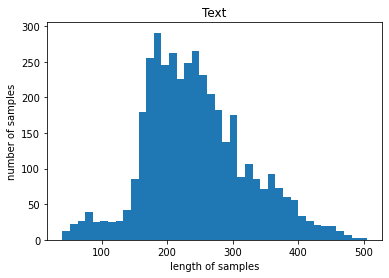

In [ ]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#### 길이분포 확인을 통한 임베딩 설정

In [ ]:
# 패딩 길이 설정

text_max_len = 400
summary_max_len = 40

In [ ]:
#max_len 보다 큰 길이를 가지는 문서 및 요약문 파악

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 400 이하인 샘플의 비율: 0.9638584247258225
전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.8693918245264207


In [ ]:
# 큰 것들은 모두 제거
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 3364


## 5. Modeling

#### decoder 토큰추가

In [ ]:
data['Text'][0]

'시어머니/NNG 아들/NNG 처자/NNG 내버리다/VV 두다/VV 채/NNB 여자/NNG 동거하다/VV 위하다/VV 여자/NNG 집/NNG 데리다/VV 오다/VV 적극/NNG 제지하다/VV 설득하다/VV 아들/NNG 하여금/MAG 하/XSA 부부/NNG 관계/NNG 가정/NNG 생활/NNG 이루다/VV 노력/NNG 기울이다/VV 아니하다/VV 물론/MAG 며느리/NNG 아들/NNG 연상/NNG 점/NNG 대하다/VV 며느리하다/VV 여기다/VV 여자/NNG 하여금/MAG 거주하다/VV 집/NNG 아들/NNG 동거/NNG 허용하다/VV 동거/NNG 장소/NNG 제공하다/VV 뿐/NNB 식사/NNG 빨래/NNG 일상/NNG 가사일/NNG 맡기다/VV 여자/NNG 봉양/NNG 받다/VV 한편/NNG 며느리/NNG 시아버지/NNG 사망/NNG 사실/NNG 알리다/VV 아니하다/VV 며느리/NNG 대신/NNG 여자/NNG 하여금/MAG 상복/NNG 입히다/VV 장례/NNG 참석하다/VV 하다/VV 추석/NNG 차례/NNG 참석하다/VV 하다/VV 여자/NNG 사실/NNG 며느리/NNG 역할/NNG 하다/VV 하다/VV 경우/NNG 시어머니/NNG 아들부부/NNG 사이/NNG 혼인/NNG 파탄/NNG 원인되다/VV 행위/NNG 가담하다/VV 것/NNB 위자료/NNG 지급/NNG 책임/NNG 있다/VV 보다/VV 사례/NNG'

In [ ]:
# seq2seq, 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,Text_original,decoder_input,decoder_target
0,시어머니/NNG 아들/NNG 처자/NNG 내버리다/VV 두다/VV 채/NNB 여자/...,시어머니가 아들이 처자를 내버려둔 채 다른 여자를 데리고 자신의 집으로 들어와 동거...,시어머니가 아들이 그 처자를 내버려둔 채 다른 여자와 동거하기 위해 그 여자를 집으...,sostoken 시어머니가 아들이 처자를 내버려둔 채 다른 여자를 데리고 자신의 집...,시어머니가 아들이 처자를 내버려둔 채 다른 여자를 데리고 자신의 집으로 들어와 동거...
1,호/NNG 정정/NNG 신청절차/NNG 의하다/VV 호적/NNG 정정/NNG 정정/...,호적정정신청절차에 의한 호적정정은 정정할 사항이 경미한 경우에 한하고 친족법상 또는...,호적정정신청절차에 의한 호적정정은 정정절차가 간이함에 비추어 정정할 사항이 경미한 ...,sostoken 호적정정신청절차에 의한 호적정정은 정정할 사항이 경미한 경우에 한하...,호적정정신청절차에 의한 호적정정은 정정할 사항이 경미한 경우에 한하고 친족법상 또는...
2,피고인하다/VV 용달화물/NNG 자동차/NNG 운송/NNG 사업/NNG 개인/NNG...,수인의 개인 용달화물 자동차운송사업자들이 사무실 등을 운영키 위한 경비를 공동으로 ...,피고인을 비롯하여 용달화물 자동차운송사업 개인별 면허를 얻어 용달차 한 대씩을 각 ...,sostoken 수인의 개인 용달화물 자동차운송사업자들이 사무실 등을 운영키 위한 ...,수인의 개인 용달화물 자동차운송사업자들이 사무실 등을 운영키 위한 경비를 공동으로 ...
3,출원/NNG 상표/NNG 출원/NNG 상표/NNG 상품/NNG 구분/NNG 제류/N...,출원상표 와 출원상표 는 식별력을 인정하기 어렵고 의약품을 취급하는 곳에서 농업용 ...,"출원상표(1) "" ""와 출원상표(2) "" ""은 상품구분 제10류의 상품군 제4에 속...",sostoken 출원상표 와 출원상표 는 식별력을 인정하기 어렵고 의약품을 취급하는...,출원상표 와 출원상표 는 식별력을 인정하기 어렵고 의약품을 취급하는 곳에서 농업용 ...
6,수인/NNG 공동하다/VV 타인/NNG 손해/NNG 가하다/VV 민법/NNG 제조/...,불법행위를 용이하게 하는 직간접의 모든 행위를 가리키는 방조는 민법 해석 상 과실에...,[1] 수인이 공동하여 타인에게 손해를 가하는 민법 제760조의 공동불법행위의 경우...,sostoken 불법행위를 용이하게 하는 직간접의 모든 행위를 가리키는 방조는 민법...,불법행위를 용이하게 하는 직간접의 모든 행위를 가리키는 방조는 민법 해석 상 과실에...


In [ ]:
encoder_input = np.array(data['Text'])
encoder_input_original = np.array(data['Text_original']) #결과확인
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

#### 데이터분리

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[1116 2357  807 ... 1294  860 3174]


In [ ]:
#순서 섞기
encoder_input = encoder_input[indices]
encoder_input_text = encoder_input_original[indices] #결과확인
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 672


In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
encoder_input_text_test = encoder_input_text[-n_of_val:] #결과확인
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [ ]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 2692
훈련 레이블의 개수 : 2692
테스트 데이터의 개수 : 672
테스트 레이블의 개수 : 672


#### 정수 인코딩

In [ ]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [ ]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 50280
등장 빈도가 6번 이하인 희귀 단어의 수: 40567
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9713
단어 집합에서 희귀 단어의 비율: 80.68217979315831
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.68176730413249


In [ ]:
src_vocab = 7500
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [ ]:
#요약 데이터에 대해 수행
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [ ]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 34417
등장 빈도가 5번 이하인 희귀 단어의 수: 32799
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 1618
단어 집합에서 희귀 단어의 비율: 95.29883487811256
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 57.8070267161604


In [ ]:
tar_vocab = 1750
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [ ]:
print(decoder_input_train[:5])

[[1, 57, 11, 35, 195, 617, 159, 6, 1300, 5, 55, 914, 81], [1, 89, 48, 144, 915, 546, 499, 617, 19, 18, 547, 785, 546, 1071, 1620, 916], [1, 11, 786, 196, 618, 52, 197, 169, 18, 787, 619, 7, 417], [1, 235, 131, 123, 359, 548, 43, 74, 185, 8], [1, 788, 186, 685, 620, 88, 187, 93, 360, 12, 9, 686, 620, 1621, 1622, 418, 1623, 212, 213]]


In [ ]:
print(decoder_target_train[:5])

[[57, 11, 35, 195, 617, 159, 6, 1300, 5, 55, 914, 81, 2], [89, 48, 144, 915, 546, 499, 617, 19, 18, 547, 785, 546, 1071, 1620, 916, 2], [11, 786, 196, 618, 52, 197, 169, 18, 787, 619, 7, 417, 2], [235, 131, 123, 359, 548, 43, 74, 185, 8, 2], [788, 186, 685, 620, 88, 187, 93, 360, 12, 9, 686, 620, 1621, 1622, 418, 1623, 212, 213, 2]]


#### 빈 샘플 제거

In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

In [ ]:
print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


In [ ]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 2692
훈련 레이블의 개수 : 2692
테스트 데이터의 개수 : 672
테스트 레이블의 개수 : 672


#### 패딩

In [ ]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

#### seq2seq + attention으로 요약 모델 설계 및 훈련시키기

In [ ]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [ ]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 400, 128)     960000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 400, 256), ( 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [ ]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

# 모델 학습 설정
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 400, 128)     960000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 400, 256), ( 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 64, callbacks=[es], epochs = 50)

Epoch 1/50
43/43 [==============================] - 192s 4s/step - loss: 2.9249 - accuracy: 0.6795 - val_loss: 1.9495 - val_accuracy: 0.7231
Epoch 2/50
43/43 [==============================] - 180s 4s/step - loss: 2.0753 - accuracy: 0.7020 - val_loss: 1.8212 - val_accuracy: 0.7320
Epoch 3/50
43/43 [==============================] - 181s 4s/step - loss: 1.9769 - accuracy: 0.7135 - val_loss: 1.7749 - val_accuracy: 0.7405
Epoch 4/50
43/43 [==============================] - 181s 4s/step - loss: 1.9280 - accuracy: 0.7210 - val_loss: 1.7463 - val_accuracy: 0.7454
Epoch 5/50
43/43 [==============================] - 180s 4s/step - loss: 1.9004 - accuracy: 0.7252 - val_loss: 1.7342 - val_accuracy: 0.7469
Epoch 6/50
43/43 [==============================] - 182s 4s/step - loss: 1.8819 - accuracy: 0.7266 - val_loss: 1.7221 - val_accuracy: 0.7474
Epoch 7/50
43/43 [==============================] - 180s 4s/step - loss: 1.8733 - accuracy: 0.7260 - val_loss: 1.7226 - val_accuracy: 0.7472
Epoch 8/50
43

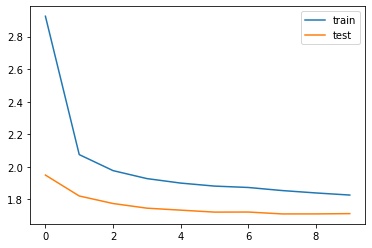

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 6. 요약 모델 테스트

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [ ]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [ ]:
for i in range(10, 20):
    print("원문 : ",encoder_input_text_test[i])
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  박종대 기자 수원시의 국제자매결연도시인 러시아 니즈니노브고로드시의 민간대표단이 28일 수원시를 방문해 경제 교류·협력 활성화 방안을 모색했다. 나탈라 흐보이노바(Khvoinova Natalya)니즈니 상공회의소 국제협력차장을 비롯해 화학제품·의료기기 업체 관계자 등 8명으로 구성된 니즈니노브고로드시 대표단은 이날 시청 영상회의실에서 원영덕 수원시 경제정책국장을 만나 협력 방안을 논의했다. 나탈라 흐보이노바 차장은 "수원시와 니즈니노브고로드시는 2005년 자매결연 이후 14년 동안 우호적인 관계를 이어오고 있다"며 "좀 더 적극적으로 민간 경제 교류를 진행하고, 지속가능한 교류·협력 방안을 모색하자"고 제안했다. 원영덕 국장은 "이번 방문이 수원시와 니즈니노브고로드시의 민간 경제 교류에 마중물이 될 것으로 본다"며 "사물인터넷(IoT)·인공지능(AI) 등 혁신기술 분야에서 적극 교류하고 함께 성장해 나가자"고 말했다. 이날 니즈니노브고로드시 대표단은 삼성전자㈜ 사업장을 둘러보고 스마트폰 등 최신 디지털 제품을 체험하기도 했다. 또 영통구 엠파이어 지식산업센터에서 수원지식산업센터협의회와 민간 경제 교류 활성화를 위한 실무 논의를 했다. 이들은 수원델타플렉스 내에 소재한 ㈜피앤이솔루션 사업장을 방문해 제품 제조공정·연구개발 시설 등을 견학하는 것으로 일정을 마쳤다. ㈜피앤이솔루션은 ‘2019년 수원시 중소기업인 대상’에서 종합대상을 받은 기업이다. 박종대 기자 pjd@kihoilbo.co.kr
실제 요약문 : 일 러시아 명과 함께 보다 적극적인 협력 활성화 방안을 
예측 요약문 :  일 일 일 일 일 년 일 일까지 개 개 개 개 개 개 개 개 개 개 개 개 개 개 일까지


원문 :  충청투데이 올 연말로 예정됐던 대전 홍도육교 지하차도 개통일이 내년 10월로 연기됐다. 당초 개통일보다 10개월가량 늦춰졌다. 공사용지 확보문제가 뒤늦게 해결됐기 때문이라고 한다. 대전시와 건축주가 철거를 둘러싸고 줄다리기를 하는 사이 공사기간이 무작정 늘어나게 됐고, 그로

# Semantic segmentation

## preprocessing

In [ ]:
seg_data.head()

,pre_article_original,pre_abstractive,label
0,[시어머니/NNG 아들/NNG 처자/NNG 내버리다/VV 두다/VV 채/NNB 여자...,"[시어머니/NNG, 아들/NNG, 처자/NNG, 내버리다/VV, 두다/VV, 채/N...",0
1,[호/NNG 정정/NNG 신청절차/NNG 의하다/VV 호적/NNG 정정/NNG 정정...,"[호/NNG, 정정/NNG, 신청절차/NNG, 의하다/VV, 호적/NNG, 정정/N...",0
2,[피고인하다/VV 용달화물/NNG 자동차/NNG 운송/NNG 사업/NNG 개인/NN...,"[수인/NNG, 개인/NNG, 용달화물/NNG, 자동차/NNG, 운송/NNG, 사업...",0
3,[출원/NNG 상표/NNG 출원/NNG 상표/NNG 상품/NNG 구분/NNG 제류/...,"[출원/NNG, 상표/NNG, 출원/NNG, 상표/NNG, 늘다/VV, 식별력/NN...",0
4,[가/NNG 피의자/NNG 피고인/NNG 사법/NNG 경찰/NNG 리/NNP 면전/...,"[피고인/NNG, 운전/NNG, 트럭/NNG, 피해자/NNG, 운전/NNG, 오토바...",0


In [ ]:
# article을 한 문서로 저장

def to_doc(text):
    doc = text[0]
    for i in range(1, len(text)):
        doc += ' '
        doc += text[i]
    return doc

#적용
seg_data['pre_article_original'] = seg_data['pre_article_original'].apply(to_doc)
seg_data.columns = ['Text', 'Summary', 'label']

#### 데이터 분리

In [ ]:
from sklearn.model_selection import train_test_split

np.random.seed(42)

features = ['Text', 'Summary']
target = ['label']

X = seg_data[features]
y = seg_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3209, 2), (803, 2), (3209, 1), (803, 1))

## 1) Text로 segmentation

In [ ]:
max_feature = 10000
tokenizer = Tokenizer(num_words=max_feature) #encoding같은 처리를 했을때 3000개로 나타내줌.

In [ ]:
tokenizer.fit_on_texts(X_train['Text'])
vocab_size = len(tokenizer.word_index)+1
vocab_size

55716

In [ ]:
X_encoded = tokenizer.texts_to_sequences(X_train['Text'])
X_encoded_test = tokenizer.texts_to_sequences(X_test['Text'])

In [ ]:
#제일 긴 문장 찾기
maxlen = np.max([len(i) for i in X_encoded])
maxlen

960

In [ ]:
X_encoded_pad = pad_sequences(X_encoded, maxlen = 600, padding='post')
X_encoded_pad_test = pad_sequences(X_encoded_test, maxlen = 600, padding='post')

#### Modeling

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras import regularizers
from tensorflow.keras import initializers

from sklearn.metrics import accuracy_score

In [ ]:
early_stop = EarlyStopping(monitor='accuracy', min_delta=0.0001, patience=5, verbose=1)

def create_model(dim):
  model = Sequential()
  model.add(Embedding(max_feature, dim, input_length=600))
  # model.add(LSTM(64, activation='relu'))
  model.add(Dense(128, activation='relu', kernel_initializer=initializers.he_normal(seed=42)))
  model.add(Dropout(0.2))
  model.add(GlobalAveragePooling1D())
  model.add(Dense(32, activation='relu',
                  kernel_regularizer=regularizers.l2(0.01),
                  activity_regularizer=regularizers.l1(0.01)))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(3, activation='softmax'))

  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy']
  )
  return model

model = KerasClassifier(build_fn=create_model, verbose=0)

#GridSearchCV
params = {
    'batch_size' : [32, 64, 128],
    'epochs' : [50],
    'dim' : [64, 128]
}

grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=5)
grid_result = grid.fit(X_encoded_pad, y_train, callbacks=[early_stop])

Epoch 00024: early stopping


In [ ]:
print('Best parameter : ', grid_result.best_params_)

Best parameter :  {'batch_size': 128, 'dim': 128, 'epochs': 50}


In [ ]:
y_pred = grid_result.predict(X_encoded_pad_test)
print('한글 문서 전체 segmentation : ', accuracy_score(y_test, y_pred))

한글 문서 전체 segmentation :  0.9240348692403487


## 2) Summary로 segmentation

In [ ]:
max_feature_su = 3000
tokenizer_su = Tokenizer(num_words=max_feature_su) #encoding같은 처리를 했을때 3000개로 나타내줌.

In [ ]:
tokenizer_su.fit_on_texts(X_train['Summary'])
vocab_size_su = len(tokenizer_su.word_index)+1
vocab_size_su

19435

In [ ]:
X_encoded_su = tokenizer_su.texts_to_sequences(X_train['Summary'])
X_encoded_su_test = tokenizer_su.texts_to_sequences(X_test['Summary'])

In [ ]:
#제일 긴 문장 찾기
maxlen_su = np.max([len(i) for i in X_encoded_su])
maxlen_su

109

In [ ]:
X_encoded_pad_su = pad_sequences(X_encoded_su, maxlen = 90, padding='post')
X_encoded_pad_su_test = pad_sequences(X_encoded_su_test, maxlen = 90, padding='post')

#### Modeling

In [ ]:
early_stop2 = EarlyStopping(monitor='accuracy', min_delta=0.0001, patience=5, verbose=1)

def create_model2(dim):
  model2 = Sequential()
  model2.add(Embedding(max_feature, dim, input_length=90))
  # model.add(LSTM(64, activation='relu'))
  model2.add(GlobalAveragePooling1D())
  model2.add(Dense(32, activation='relu'))
  model2.add(Dense(3, activation='softmax'))

  model2.compile(
      loss='sparse_categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy']
  )
  return model2

model2 = KerasClassifier(build_fn=create_model2, verbose=0)

#GridSearchCV
params2 = {
    'batch_size' : [16, 32, 64, 128],
    'epochs' : [50],
    'dim' : [32, 64, 128]
}

grid2 = GridSearchCV(estimator=model2, param_grid=params2, n_jobs=-1, cv=5)
grid_result2 = grid2.fit(X_encoded_pad_su, y_train, callbacks=[early_stop2])

Epoch 00022: early stopping


In [ ]:
print('Best parameter : ', grid_result2.best_params_)

Best parameter :  {'batch_size': 32, 'dim': 128, 'epochs': 50}


In [ ]:
y_pred2 = grid_result2.predict(X_encoded_pad_su_test)
print('Summary segmentation : ', accuracy_score(y_test, y_pred2))

Summary segmentation :  0.8841843088418431


## Reference

https://aihub.or.kr/ - 데이터 출처<br>
https://wikidocs.net/72820<br>
http://aidev.co.kr/nlp/9480